In [2]:
## Download dataset and required packages if necessary
# !pip install git+https://github.com/neurallatents/nlb_tools.git
# !pip install dandi
!dandi download https://gui.dandiarchive.org/#/dandiset/000129 -o "../Datasets"

In [1]:
## Imports

# %matplotlib widget # uncomment for interactive plots
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Dataset Setup


In [3]:
## Load dataset
data_dir = os.path.join("..", "Datasets", "000129", "sub-Indy")
dataset = NWBDataset(data_dir, "*train", split_heldout=False)

In [4]:
## Make trial data

# Find when target pos changes
has_change = dataset.data.target_pos.fillna(-1000).diff(axis=0).any(axis=1) # filling NaNs with arbitrary scalar to treat as one block
# Find if target pos change corresponds to NaN-padded gap between files
change_nan = dataset.data[has_change].isna().any(axis=1)
# Drop trials containing the gap and immediately before and after, as those trials may be cut short
drop_trial = (change_nan | change_nan.shift(1, fill_value=True) | change_nan.shift(-1, fill_value=True))[:-1]
# Add start and end times to trial info
change_times = dataset.data.index[has_change]
start_times = change_times[:-1][~drop_trial]
end_times = change_times[1:][~drop_trial]
# Get target position per trial
target_pos = dataset.data.target_pos.loc[start_times].to_numpy().tolist()
# Compute reach distance and angle
reach_dist = dataset.data.target_pos.loc[end_times - pd.Timedelta(1, 'ms')].to_numpy() - dataset.data.target_pos.loc[start_times - pd.Timedelta(1, 'ms')].to_numpy()
reach_angle = np.arctan2(reach_dist[:, 1], reach_dist[:, 0]) / np.pi * 180
# Create trial info
dataset.trial_info = pd.DataFrame({
    'trial_id': np.arange(len(start_times)),
    'start_time': start_times,
    'end_time': end_times,
    'target_pos': target_pos,
    'reach_dist_x': reach_dist[:, 0],
    'reach_dist_y': reach_dist[:, 1],
    'reach_angle': reach_angle,
})

In [5]:
## Optional resampling
# It may be beneficial to resample the data before you proceed to the analysis sections,
# as they may be fairly memory-intensive. However, we have not tested this notebook at bin sizes
# of over 20 ms, so we cannot guarantee that everything will work as intended at
# those larger bin sizes.
dataset.resample(5)

In [6]:
## Compute speed onset for each reach, for plotting alignment

# Calculate speed and call `calculate_onset`
speed = np.linalg.norm(dataset.data.finger_vel, axis=1)
dataset.data['speed'] = speed
peak_times = dataset.calculate_onset('speed', 0.05)

nans = dataset.data.finger_vel.x.isna().reset_index(drop=True)
dataset.data = dataset.data.iloc[~nans.to_numpy()]


In [7]:
## Helper Functions

def decode(neural, kinematics):
    gscv = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 9)})
    gscv.fit(neural, kinematics)
    print(f'Decoding R2: {gscv.best_score_}')
    predictions = gscv.predict(neural)
    
    return predictions
    
def decode_and_plot_rtt(rates, vel, vel_index, dataset):
    
    plotting_dataset = copy.copy(dataset)
    pred_vel = decode(rates, vel)

    # Add data back to main dataframe
    pred_vel_df = pd.DataFrame(pred_vel, index=vel_index, columns=pd.MultiIndex.from_tuples([('pred_vel', 'x'), ('pred_vel', 'y')]))
    plotting_dataset.data = pd.concat([dataset.data, pred_vel_df], axis=1)
    
    ## Plot predicted vs true kinematics

    # Coloring function
    get_color = lambda idx, series: plt.get_cmap('Greens')((series[idx] - series.min()) / (series.max() - series.min()))
    # Extract trial data aligned to movement onset
    trial_data = plotting_dataset.make_trial_data(align_field='speed_onset', align_range=(-100, 400), allow_nans=True)

    # Initialize figure
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    # Loop through trials and plot on appropriate subplots
    for tid, trial in trial_data.groupby('trial_id'):
        axs[0][0].plot(np.arange(-100, 400, plotting_dataset.bin_width), trial.finger_vel.x, color=get_color(tid, plotting_dataset.trial_info.reach_dist_x))
        axs[0][1].plot(np.arange(-100, 400, plotting_dataset.bin_width), trial.finger_vel.y, color=get_color(tid, plotting_dataset.trial_info.reach_dist_y))
        axs[1][0].plot(np.arange(-100, 400, plotting_dataset.bin_width), trial.pred_vel.x, color=get_color(tid, plotting_dataset.trial_info.reach_dist_x))
        axs[1][1].plot(np.arange(-100, 400, plotting_dataset.bin_width), trial.pred_vel.y, color=get_color(tid, plotting_dataset.trial_info.reach_dist_y))

    # Add labels
    axs[0][0].set_title('X velocity')
    axs[0][1].set_title('Y velocity')
    axs[0][0].set_ylabel('True velocity')
    axs[1][0].set_ylabel('Predicted velocity')
    axs[1][0].set_xlabel('Time after move onset (ms)')
    axs[1][1].set_xlabel('Time after move onset (ms)')
    axs[0][0].set_xlim(-100, 400)
    plt.show()

# Tips and Tricks for Decoding Neural Data

Neural data can be hard to work with for a variety of reasons. The signal-to-noise ratio is generally low, and the data can be hard to interpret. If the raw neural recordings are fed into a decoding algorithm, the performance is generally low. However, some preprocessing steps can drastically improve decoding performance. Some of these preprocessing steps are discussed below. 

### Note:
Each technique below will be applied indpendently, with the exception of smoothing. This step makes a large difference in the decoding performance, so all other methods will be applied after the data has been smoothed.


### Decoding raw spiking rates and velocities
As mentioned above, when neural data is fed into a decoder with no preprocessing, the performance is generally low. The code section below demonstrates this.

Decoding R2: 0.03261370859012034


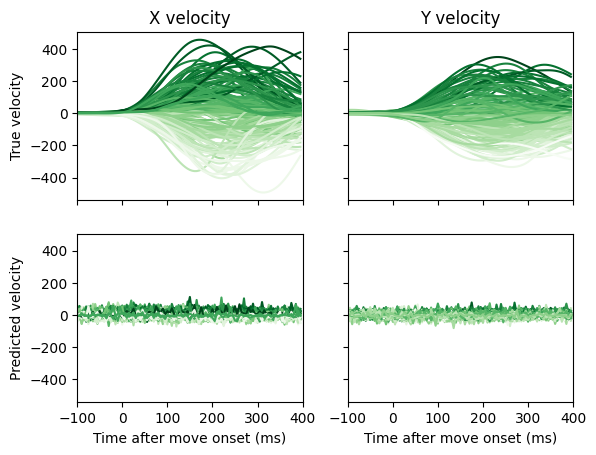

In [8]:
rates = dataset.data.spikes.to_numpy()
vel = dataset.data.finger_vel.to_numpy()
vel_index = dataset.data.finger_vel.index

decode_and_plot_rtt(rates, vel, vel_index, dataset)

### Smoothing
Although smoothing can lead to some information loss, it frequently improves decoding performance. This is because much of the variability removed is noise. Therefore, the signal to noise ratio is increased, providing the decoder with better features to learn. 

Smoothing can be done in a few ways, but the methods used most frequently are a moving average or a gaussian convolution. Which one works better depends on the application.

Decoding R2: 0.3621422125214771


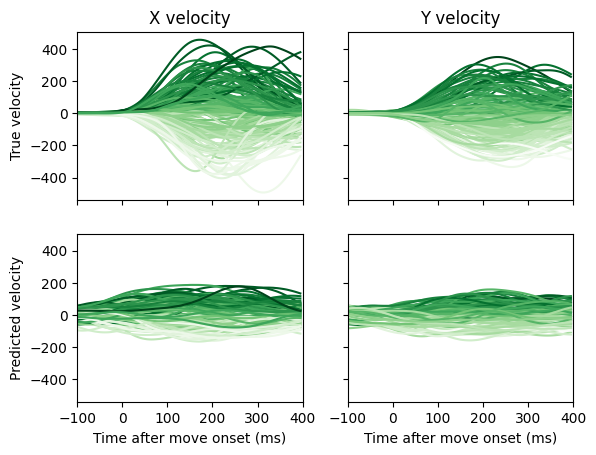

Decoding R2: 0.4061097987098849


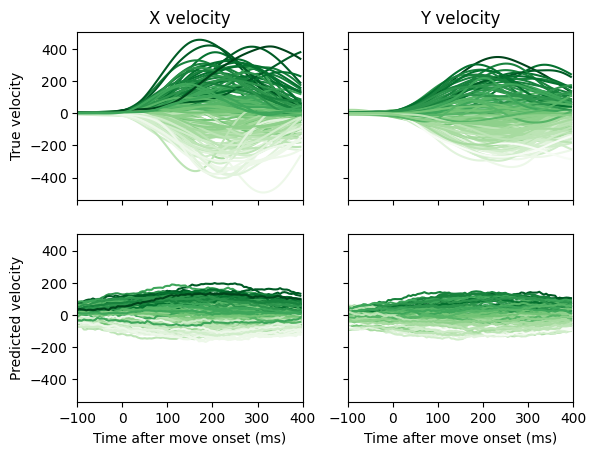

In [9]:
def moving_average(data, window_size):
    """
    Apply a moving average to each column of the 2D array 'data'.
    
    Parameters:
    - data (np.ndarray): 2D array of shape (t, n) where t is the time dimension and n is the number of data points.
    - window_size (int): The size of the moving window.
    
    Returns:
    - smoothed_data (np.ndarray): The array after applying the moving average, same shape as input.
    """
    # Ensure that data is a 2D array
    data = np.asarray(data)
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D array.")
    
    # Create an empty array to hold the smoothed data
    smoothed_data = np.zeros_like(data)

    # Apply moving average along each column
    for i in range(data.shape[1]):
        smoothed_data[:, i] = np.convolve(data[:, i], np.ones(window_size)/window_size, mode='same')
    
    return smoothed_data

def gaussian_smooth(data, std):
    if (f'spikes_smth_{std}' in dataset.data) == False:
        dataset.smooth_spk(50, name=f'smth_{std}', ignore_nans=True)
    
    return dataset.data.spikes_smth_50.to_numpy()

# Smooth spikes with Gaussian
gaussian_std = 50 # ms
gauss_smoothed_rates = gaussian_smooth(rates, gaussian_std)
decode_and_plot_rtt(gauss_smoothed_rates, vel, vel_index, dataset)


# Smooth using moving average
mavg_window_size = 75
mavg_smoothed_rates = moving_average(rates, mavg_window_size)
decode_and_plot_rtt(mavg_smoothed_rates, vel, vel_index, dataset)

Feel free to adjust the std or window size in the smoothing methods to see how decoding performance is affected

## Introducing lag

Introducing lag to the neural data by shifting the neural data forward relative to the behavior being predicted can improve decoding performance. This is because the behaviour at a given timepoint was likely caused by neural data at a previous time point. The amount of lag necessary can vary, so you should try different lag values.

Decoding R2: 0.44863802539004516


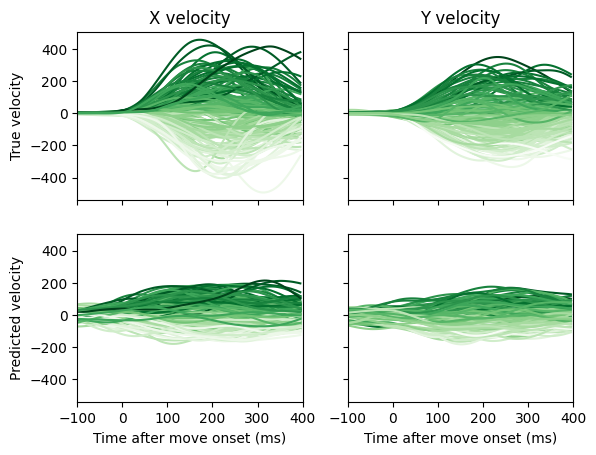

In [10]:
lag = 13
decode_and_plot_rtt(gauss_smoothed_rates[:-lag], vel[lag:], vel_index[lag:], dataset)


Feel free to adjust the lag size to see how decoding performance is affected

## Time History
This is similar to introducing lag, however, it provides the decoder with more information. Instead of simply shifting the neural data, it adds additional dimensions to the neural data where each added dimension has lagged data. This easier to visualize than explain, so it is demonstrated below. 


In [12]:
import random
def add_time_history(rates, n_history_rows = 3):
    rates_array = np.empty([rates.shape[0], rates.shape[1]*n_history_rows])
    rates_array[:, :] = np.nan
    nsamples = rates.shape[0]
    for i in range(rates.shape[1]):
        rates_array[:, n_history_rows*i] = rates[:, i]
        
        for j in range(n_history_rows-1):

            rates_array[j+1:, n_history_rows*i+j+1] = rates[:nsamples-(j+1), i]
            
    return rates_array

data = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]).T
time_history_data = add_time_history(data, 3)
print(f"Original data: \n {data}")
print(f"Data with time history: \n {time_history_data}")



Original data: 
 [[  1  10]
 [  2  20]
 [  3  30]
 [  4  40]
 [  5  50]
 [  6  60]
 [  7  70]
 [  8  80]
 [  9  90]
 [ 10 100]]
Data with time history: 
 [[  1.  nan  nan  10.  nan  nan]
 [  2.   1.  nan  20.  10.  nan]
 [  3.   2.   1.  30.  20.  10.]
 [  4.   3.   2.  40.  30.  20.]
 [  5.   4.   3.  50.  40.  30.]
 [  6.   5.   4.  60.  50.  40.]
 [  7.   6.   5.  70.  60.  50.]
 [  8.   7.   6.  80.  70.  60.]
 [  9.   8.   7.  90.  80.  70.]
 [ 10.   9.   8. 100.  90.  80.]]


You'll notice that the final data has nans where data isn't available to be added. Therefore, the data has to be clipped, meaning that some data is lost. 

You'll also notice that this improves the performance more than introducing lag, however, this comes at a cost. By increasing the amount of data fed into the decoder, the computation time is increased. Therefore, a choice must be made between decoding perfromance and computation time.

Decoding R2: 0.4850470111395183


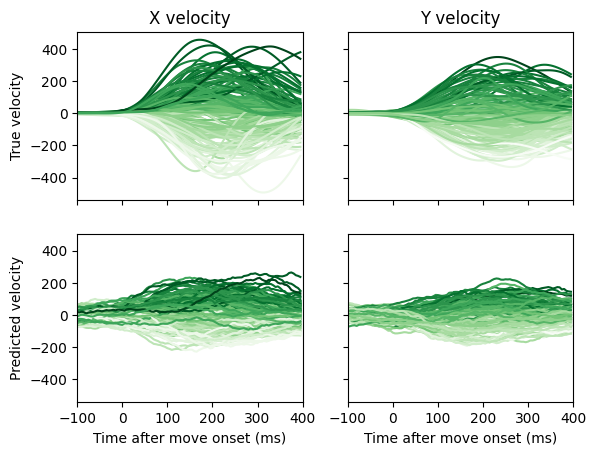

In [14]:
def add_time_history_and_clip(rates, dataset, n_history_rows = 10):
    
    rates_array = add_time_history(rates, n_history_rows)
    
    clipped_dataset = copy.copy(dataset)
    clipped_dataset.data = clipped_dataset.data.iloc[n_history_rows-1:]

    return rates_array[n_history_rows-1:], clipped_dataset


n_history_dimensions = 10
rates_array, clipped_dataset = add_time_history_and_clip(gauss_smoothed_rates, dataset, n_history_dimensions)

clipped_vel = clipped_dataset.data.finger_vel.to_numpy()
clipped_vel_index = clipped_dataset.data.finger_vel.index

decode_and_plot_rtt(rates_array, clipped_vel, clipped_vel_index, clipped_dataset)

Feel free to adjust the number of additional history dimensions added to see how decoding performance is affected

Decoding R2: 0.3598278800204787


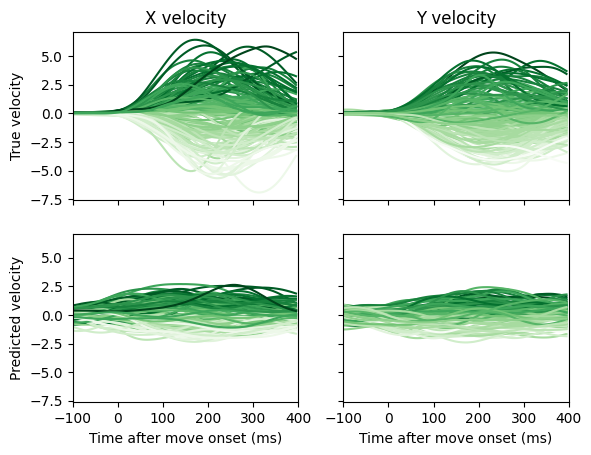

In [ ]:
def normalize(X):
    # Calculate the mean and standard deviation along the time axis (axis=0)
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # Avoid division by zero by replacing zeros in std with a small value
    std[std == 0] = 1e-10

    # Z-score normalization
    Z = (X - mean) / std
    return Z

normalized_rates = normalize(gauss_smoothed_rates)
normalized_vels = normalize(vel)


normalized_dataset = copy.copy(dataset)
normalized_dataset.data.finger_vel = normalized_vels

decode_and_plot_rtt(normalized_rates, normalized_vels, vel_index, normalized_dataset)


## CAR
Common Average Referencing (CAR) involves calculating the mean of all signals recorded from an electrode and subtracting it from the recordings at each channel. This aims to remove common noise sources and artifacts. 
<br> <br> This cannot be applied to the NLB-rtt dataset that we are currently working with, as the data has already been sorted into spike times. However, when working with raw neural data, CAR can greatly improve the signal-to-noise ratio and improve decoding performance. 

## Trial Averaging
If many trials are performed with the same task context (i.e. same target position or reach conditions), that means that multiple samples of the neural data driving a specific behavior are available. It can be beneficial to average over all of these samples in order to remove noise and obtain a single representative neural signal underlying a specific behavior. This is not always useful with neural decoding as task contexts can vary and online decoding would not allow for this type of analysis. However, this can be beneficial for analyzing the relationship between neural activity and behavior.
<br> <br> Due to a lack of a clear task structure, trial averaging is difficult to apply to this dataset. However, it is worth trying on datasets with distinct task structures.


## Applying multiple methods
Each of the methods above were applied independently (except for smoothing). Feel free to try different combinations of techinques below and see how different combinations affect performance. You can also adjust the values to each of the functions such as the smoothing window size, or the amount of lag added

In [ ]:
decoding_rates = 
decoding_vels = 

decode_and_plot_rtt(decoding_rates, decoding_vels, vel_index, dataset)


# Function Reuse
The functions above should be able to be applied to any data array, assuming that it is of shape [t timepoints x n features]. Feel free to use them on your own data. 